<a href="https://colab.research.google.com/github/Tucker6742/CNN-sex-and-gender/blob/main/Sigmoid_Best_Ejoyer_of_CNN_Sex_and_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle           

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/kaggle.json" ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 98% 325M/331M [00:04<00:00, 106MB/s] 
100% 331M/331M [00:04<00:00, 85.7MB/s]


In [ ]:
!unzip -qq /content/utkface-new.zip -d /content/file

$\huge\text{Import library}$


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random

In [ ]:
import tensorflow as tf
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K


In [ ]:
base_path = "/content/file/UTKFace/"
files = os.listdir(base_path)
size = len(files)

$\huge\text{Pre processing data}$


In [ ]:
# Preprocessing
shape = 70
images = []
ages = []
genders = []
i =0
for items in files:
    image = cv2.imread(base_path+items, 0)
    image = cv2.resize(image, dsize=(shape, shape))
    image = image.reshape((image.shape[0], image.shape[1], 1))
    images.append(image)
    split_var = items.split('_')
    ages.append(int(split_var[0]))
    genders.append(int(split_var[1]))



In [ ]:
# Encode age to 20 parts
def age_group(age):
    return min(age//5, 19)
    

In [ ]:
# Feature scaling 
target = np.zeros((size, 2), dtype = 'float64')
feature = np.zeros((size, shape, shape, 1), dtype = 'float64')

# Save a copy of the datatset
for i in range (size):
    target[i, 0] = ages[i]
    target[i, 1] = genders[i]
    feature[i] = images[i]
feature = feature/255 # Scaling the image

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Split dataset into train and test (80 : 20)
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, shuffle  = True)

print("Samples in Training:",x_train.shape)
print("Samples in Testing:",x_test.shape)

# Encode the age in the train set to 20 parts
for i in range(len(y_train)):
    y_train[i][0] = age_group(y_train[i][0])

C = tf.constant(20, name = "C") #20 classes
age_one_hot = np.array(tf.one_hot(
    y_train[:, 0], C, on_value = 1.0, off_value = 0.0, axis = 1))

# Define the age set and gender set in train set
age_y_train = age_one_hot
gender_y_train = y_train[:, 1]




Samples in Training: (18966, 70, 70, 1)
Samples in Testing: (4742, 70, 70, 1)


$\huge\text{Make model}$

In [ ]:
def img_cnn(drop_rate = 0):
	inputs = Input(shape=(shape,shape,1))
	conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
	conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
	pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
 
	conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool2)
	pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
	conv4 = Conv2D(256, kernel_size=(3, 3),activation='relu')(pool3)
	pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
	conv5 = Conv2D(512, kernel_size=(3, 3),activation='relu')(pool4)
	pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
 
	x = Dropout(0.25)(pool5)
	flat = Flatten()(x)
	return inputs, flat

def modeling(flat, drop_rate = 0):
	dropout = Dropout(drop_rate)
	age_model = Dense(512, activation='relu')(flat)
	age_model = dropout(age_model)
	age_model = Dense(256, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(128, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(64, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(32, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(20, activation='sigmoid')(age_model)

	dropout = Dropout(drop_rate)
	gender_model = Dense(128, activation='relu')(flat)
	gender_model = dropout(gender_model)
	gender_model = Dense(64, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(32, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(16, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(8, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(1, activation='sigmoid')(gender_model)
	return age_model, gender_model

In [ ]:
#CNN the image
push, pull = img_cnn(0.5)

#Age and gender model
age_model, gender_model = modeling(pull, 0.25)

Age_model = Model(inputs = push, outputs = age_model)
Gender_model = Model(inputs = push, outputs = gender_model)
Age_model.compile(optimizer = 'adam', loss =['binary_crossentropy'],metrics=['accuracy'])
Gender_model.compile(optimizer = 'adam', loss =['binary_crossentropy'],metrics=['accuracy'])


In [ ]:
Age_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 70, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 68, 68, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 66, 66, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 33, 33, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
Gender_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 70, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 68, 68, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 66, 66, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 33, 33, 64)   0           ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
def own_cnn(log, EPOCHS, check, train_index, test_index):
    
    from keras.callbacks import CSVLogger

    # Use k-fold
    X_train = x_train[train_index]
    Age_Y_train = age_y_train[train_index]
    Gender_Y_train = gender_y_train[train_index]


    X_test = x_train[test_index]
    Age_Y_test = age_y_train[test_index]
    Gender_Y_test = gender_y_train[test_index]

    # Create log and fit the train
    print(f"--------------------------------------------Age Fold {log}------------------------------------------------------------------")
    age_logger = CSVLogger(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Logs/age model fold {log}.log', separator=',', append=check)
    A = Age_model.fit(X_train,Age_Y_train, validation_data = (X_test, Age_Y_test), epochs = EPOCHS, callbacks=[age_logger], batch_size = BATCH_SIZE, shuffle = True) 

    print(f"--------------------------------------------Gender Fold {log}------------------------------------------------------------------")
    gender_logger = CSVLogger(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Logs/gender model fold {log}.log', separator=',', append=check)
    G = Gender_model.fit(X_train,Gender_Y_train, validation_data = (X_test, Gender_Y_test), epochs = EPOCHS, callbacks=[gender_logger], batch_size = BATCH_SIZE, shuffle = True)

    # Save model
    Gender_model.save(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Models/gender model.h5') 
    Age_model.save(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Models/age model.h5')


In [ ]:
# Here is to save the train and test index after using kfold
train_indexes = []
test_indexes = []

In [ ]:
c = input("Train from the last epoch? (Y/N): ")

if c == 'N':

    kf = KFold(n_splits = 10, random_state = 42, shuffle = True) 
    log = 0 # To keep track of the index of trained model 

    for j in range(2): # Train 20 times
        # define training hyperparameters
        BATCH_SIZE = 25
        EPOCHS = 15

        for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
            if i == 9:
                EPOCHS = 2 # The last train in 10 folds will train with 2 epochs to prevent overfitting
            log = log+1

		    # Keep the train and test index to train from the last model
            train_indexes.append(train_index)
            test_indexes.append(test_index)

                             
            # train 
            own_cnn(log, EPOCHS , False, train_index, test_index)
            EPOCHS -= 1 # Decrease one epoch after training each fold to prevent overfitting
        
else:
    log = 9 #index of last log save in drive
    check = False # Check if last log index >= 10
    for j in range(2): # Train 20 times

        if log >= 10 and check == False: # If last log index >= 10
            log = log - 10
            check = True
            continue # Skip first iteration if last log index >= 10 

        elif log >= 10 and check == True:
            log = log - 10 # To train after iterating through 10 folds in the first iteration

        # define training hyperparameters
        BATCH_SIZE = 25
        EPOCHS = 15
        for i in range(log, 10, 1): 
            if i == 9:
                EPOCHS = 2
            log = log + 1
    
            # train 
            own_cnn(log, EPOCHS, True, train_indexes[log], test_indexes[log])
            EPOCHS -= 1 # Decrease one epoch after training each fold to prevent overfitting


In [ ]:
%matplotlib inline
plt.close('all')
for i in range(20):
    # Get the log files
    age_history = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/Logs-20230315T032530Z-001/Logs/age model fold {i+1}.log')
    gender_history = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/Logs-20230315T032530Z-001/Logs/gender model fold {i+1}.log')

    # Plot
    plt.plot(age_history['epoch'], age_history['accuracy'])
    plt.plot(age_history['epoch'], age_history['val_accuracy'])
    plt.plot(gender_history['epoch'], gender_history['accuracy'])
    plt.plot(gender_history['epoch'], gender_history['val_accuracy'])
    plt.title(f'model fold {i + 1} accuracy')
    plt.ylabel(f'val accuracy fold {i + 1}')
    plt.xlabel('epoch')
    plt.legend(['age_train', 'age_val', 'gender_train', 'gender_val'], loc='upper left')
    plt.show()

In [ ]:
# This is the best model of us
age_model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/20 part age model.h5')
gender_model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/20 part gender model.h5')

# Load model
#age_model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Models/age model fold.h5')
#gender_model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Models/gender model.h5')

In [ ]:
def decode_one_hot(age_one_hot):
    return np.argmax(age_one_hot[0]) # return the highest value of the sigmoid array


def get_age(d):
    if 0 <= d <= 19:
        return f"{d*5} - {d*5+4}"

    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    age_val = age_model.predict(np.array([sample]))
    gender_val = gender_model.predict(np.array([sample]))
    age_val = decode_one_hot(age_val)
    #print("Index predicted: ", age_val)
    age = get_age(age_val)
    gender = get_gender(gender_val)
    #print("Predicted Gender:",gender,"Predicted Age:",age)
    return age, gender, age_val
    
    


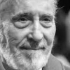

Actual Gender: Male
Age: 75
1/1 [==============================] - 0s 126ms/step
Index predicted:  15
Predicted Gender: Male Predicted Age: 75 - 79


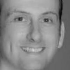

Actual Gender: Male
Age: 36
1/1 [==============================] - 0s 32ms/step
Index predicted:  7
Predicted Gender: Male Predicted Age: 35 - 39


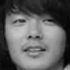

Actual Gender: Male
Age: 29
1/1 [==============================] - 0s 36ms/step
Index predicted:  5
Predicted Gender: Male Predicted Age: 25 - 29


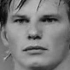

Actual Gender: Male
Age: 25
1/1 [==============================] - 0s 32ms/step
Index predicted:  5
Predicted Gender: Male Predicted Age: 25 - 29


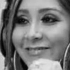

Actual Gender: Female
Age: 27
1/1 [==============================] - 0s 33ms/step
Index predicted:  5
Predicted Gender: Female Predicted Age: 25 - 29


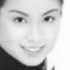

Actual Gender: Female
Age: 27
1/1 [==============================] - 0s 43ms/step
Index predicted:  4
Predicted Gender: Female Predicted Age: 20 - 24


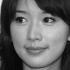

Actual Gender: Female
Age: 29
1/1 [==============================] - 0s 32ms/step
Index predicted:  6
Predicted Gender: Female Predicted Age: 30 - 34


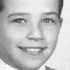

Actual Gender: Male
Age: 10
1/1 [==============================] - 0s 36ms/step
Index predicted:  2
Predicted Gender: Male Predicted Age: 10 - 14


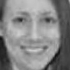

Actual Gender: Female
Age: 28
1/1 [==============================] - 0s 24ms/step
Index predicted:  5
Predicted Gender: Female Predicted Age: 25 - 29


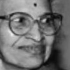

Actual Gender: Female
Age: 73
1/1 [==============================] - 0s 26ms/step
Index predicted:  15
Predicted Gender: Female Predicted Age: 75 - 79


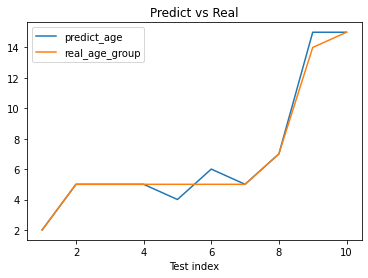

In [ ]:
import copy

n_test = 10 # Number of samples for quick test

# Here is to save the predict and real to summarize later
predict_age = []
real_age_group = []

# Random n_test tests
index = [random.randint(0, 18966) for i in range(n_test)]
for i in index:
    sample = images[i]
    cv2_imshow(sample)
    print("Actual Gender:",get_gender(genders[i]))
    print("Age:",ages[i])
    age, gender, age_val = get_result(sample)
    predict_age.append(age_val)
    real_age_group.append(age_group(ages[i]))

real = real_age_group.copy()
predict = predict_age.copy()

# Sort the list of real and predict for the plot to be more easily observed
real_age_group = np.array(real_age_group)
predict_age = np.array(predict_age)
predict_age = predict_age.reshape(n_test)

inds = real_age_group.argsort()
sorted_predict_age = predict_age[inds]
real_age_group.sort()

# Plot the real and predict line
%matplotlib inline
plt.close('all')
test = [i+1 for i in range(n_test)]
plt.plot(test, sorted_predict_age)
plt.plot(test, real_age_group)
plt.title("Predict vs Real")
plt.xlabel('Test index')
plt.legend(['predict_age', 'real_age_group'], loc='upper left')
plt.show()

In [ ]:
import copy
# Predict the test

# Here is to save the predict and real to summarize later
predict_age = []
real_age_group = []

for i in range(len(x_test)):
    sample = x_test[i] * 255
    #cv2_imshow(sample)
    #print("Actual Gender:",get_gender(y_test[i][1]))
    #print("Age:",y_test[i][0])
    age, gender, age_val = get_result(sample)
    predict_age.append(age_val)
    real_age_group.append(age_group(y_test[i][0]))

real = real_age_group.copy()
predict = predict_age.copy()

# Sort the list of real and predict for the plot to be more easily observed
real_age_group = np.array(real_age_group)
predict_age = np.array(predict_age)

inds = real_age_group.argsort()
sorted_predict_age = predict_age[inds]
real_age_group.sort()



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 42ms/step


In [ ]:
df = pd.DataFrame([sorted_predict_age, real_age_group])
df = df.T
df.rename(columns = {0:"Predict",1:"Real"},inplace=True)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/test.csv')

Predict mean:  6.303458456347533
Real mean:  6.44517081400253
Predict variance:  15.362228070304978
Real variance:  16.681131493701887


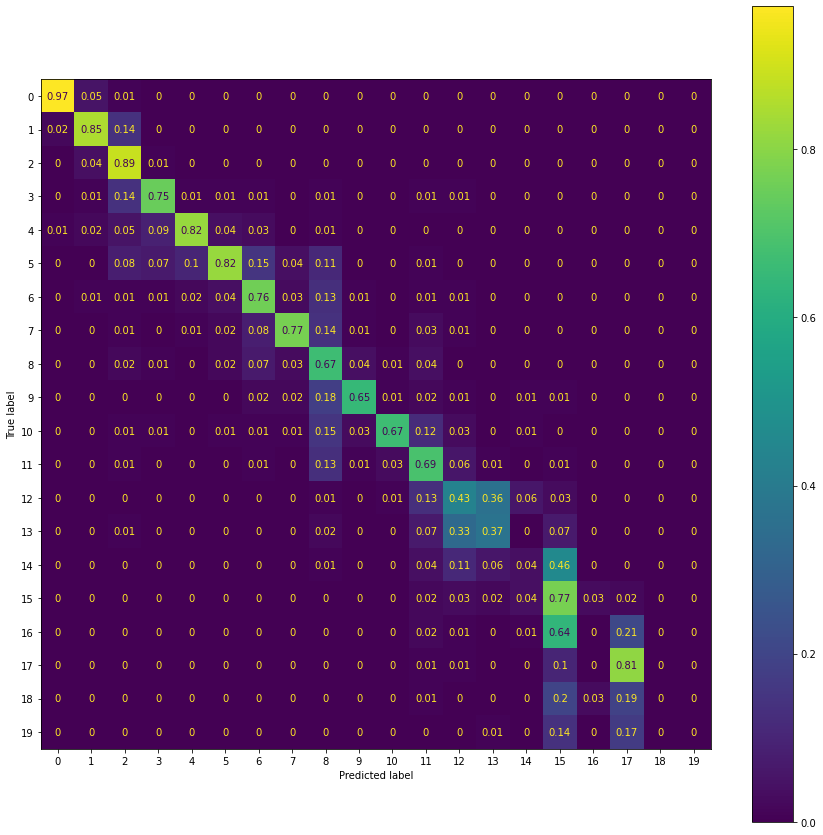

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/test.csv')
print('Predict mean: ', df['Predict'].mean())
print('Real mean: ', df['Real'].mean())
print('Predict variance: ', df['Predict'].var())
print('Real variance: ', df['Real'].var())
classes = [i for i in range(20)]
cm = confusion_matrix(df['Real'], df['Predict'], labels=classes)
cm = cm/cm.astype(float).sum(axis=1)
cm = cm.round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes)

disp.plot()
plt.rcParams['figure.figsize'] = (45, 45)
plt.show()

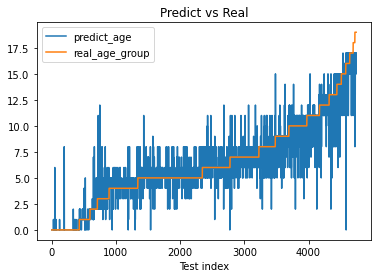

Accuracy:  0.7397722479966259


In [ ]:
#Plot the real and predict line
%matplotlib inline
plt.close('all')
test = [i+1 for i in range(len(df))]
plt.plot(test, df['Predict'])
plt.plot(test, df['Real'])
plt.title("Predict vs Real")
plt.xlabel('Test index')
plt.legend(['predict_age',  'real_age_group'], loc='upper left')
plt.rcParams['figure.figsize'] = [60, 60]
plt.show()

#Accuracy
accuracy = 0
for i in range(len(df)):
    if df['Predict'][i] == df['Real'][i]:
        accuracy = accuracy + 1
accuracy = accuracy/len(df['Real'])
print('Accuracy: ', accuracy)
